In [1]:
# Install the following dependencies to run this example notebook:
# xarray[complete] requests geopandas xvec
from datetime import datetime, timedelta, timezone

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import xarray as xr
import xvec

In [2]:
# Open the dynamical.org GEFS forecast dataset
# Dataset documentation: https://dynamical.org/catalog/noaa-gefs-forecast

gefs_ds = xr.open_zarr("s3://us-west-2.opendata.source.coop/dynamical/noaa-gefs-forecast/v0.1.0.zarr", decode_timedelta=True)
gefs_ds

<xarray.Dataset> Size: 188TB
Dimensions:                                         (init_time: 414,
                                                     ensemble_member: 31,
                                                     lead_time: 181,
                                                     latitude: 721,
                                                     longitude: 1440)
Coordinates:
  * ensemble_member                                 (ensemble_member) uint16 62B ...
    expected_forecast_length                        (init_time) timedelta64[ns] 3kB dask.array<chunksize=(414,), meta=np.ndarray>
    ingested_forecast_length                        (init_time, ensemble_member) timedelta64[ns] 103kB dask.array<chunksize=(414, 31), meta=np.ndarray>
  * init_time                                       (init_time) datetime64[ns] 3kB ...
  * latitude                                        (latitude) float64 6kB 90...
  * lead_time                                       (lead_time) timedelta64[ns] 1kB ...
  * longitude                                       (longitude) float64 12kB ...
    spatial_ref                                     int64 8B ...
    valid_time                                      (init_time, lead_time) datetime64[ns] 599kB dask.array<chunksize=(414, 181), meta=np.ndarray>
Data variables: (12/34)
    categorical_freezing_rain_surface               (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    categorical_freezing_rain_surface_avg           (init_time, lead_time, latitude, longitude) float32 311GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
    categorical_ice_pellets_surface                 (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    categorical_ice_pellets_surface_avg             (init_time, lead_time, latitude, longitude) float32 311GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
    categorical_rain_surface                        (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    categorical_rain_surface_avg                    (init_time, lead_time, latitude, longitude) float32 311GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
    ...                                              ...
    wind_u_100m                                     (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    wind_u_10m                                      (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    wind_u_10m_avg                                  (init_time, lead_time, latitude, longitude) float32 311GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
    wind_v_100m                                     (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    wind_v_10m                                      (init_time, ensemble_member, lead_time, latitude, longitude) float32 10TB dask.array<chunksize=(1, 31, 181, 73, 72), meta=np.ndarray>
    wind_v_10m_avg                                  (init_time, lead_time, latitude, longitude) float32 311GB dask.array<chunksize=(1, 181, 146, 144), meta=np.ndarray>
Attributes:
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    dataset_id:           noaa-gefs-forecast
    description:          Weather forecasts from the Global Ensemble Forecast...
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...
    name:                 NOAA GEFS forecast
    spatial_domain:       Global
    spatial_resol

## Single station analysis
Lets start by using the NOAA weather station API and the dynamical.org GEFS zarr dataset to 
compare forecasts and observations at a single site.

In [3]:
# Retrieve weather station information from api.weather.gov
station_id = "KDFW" # Dallas/Fort Worth International Airport
station_info = requests.get(f"https://api.weather.gov/stations/{station_id}").json()
station_lon, station_lat = station_info["geometry"]["coordinates"]

In [4]:
# Retrieve recent observations from the selected weather station
end_time = datetime.now(timezone.utc)
start_time = end_time - timedelta(days=7)
start_time_utc = start_time.replace(tzinfo=None)  # xarray doesn't love time zone aware dates unfortunately

station_observations_response = requests.get(
    f"https://api.weather.gov/stations/{station_id}/observations", 
    params={"start": start_time.isoformat(), "end": end_time.isoformat()}
)

observations = [obs["properties"] for obs in station_observations_response.json()["features"]]

timestamps = [obs["timestamp"] for obs in observations]
values = [{key: obs[key]["value"] for key in obs if isinstance(obs[key], dict)} for obs in observations]

station_df = pd.DataFrame(values, index=pd.DatetimeIndex(timestamps), dtype=float).sort_index()
station_df

,elevation,temperature,dewpoint,windDirection,windSpeed,windGust,barometricPressure,seaLevelPressure,visibility,maxTemperatureLast24Hours,minTemperatureLast24Hours,precipitationLastHour,precipitationLast3Hours,precipitationLast6Hours,relativeHumidity,windChill,heatIndex
2025-02-10 15:10:00+00:00,182.0,5.0,3.9,60.0,16.56,NaN,102540.0,NaN,8050.0,NaN,NaN,NaN,NaN,NaN,92.595620,1.534033,NaN
2025-02-10 15:53:00+00:00,182.0,4.4,3.3,50.0,18.36,NaN,102570.0,102570.0,8050.0,NaN,NaN,NaN,NaN,NaN,92.560962,0.537772,NaN
2025-02-10 16:13:00+00:00,182.0,5.0,3.3,60.0,16.56,NaN,102570.0,NaN,3220.0,NaN,NaN,0.0,NaN,NaN,88.764904,1.534033,NaN
2025-02-10 16:53:00+00:00,182.0,5.0,3.9,70.0,11.16,NaN,102540.0,102530.0,3220.0,NaN,NaN,0.0,NaN,NaN,92.595620,2.433569,NaN
2025-02-10 17:53:00+00:00,182.0,5.6,3.9,90.0,12.96,NaN,102440.0,102430.0,11270.0,NaN,NaN,0.0,NaN,0.0,88.816089,2.830437,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-17 08:53:00+00:00,182.0,0.6,-6.1,100.0,11.16,NaN,102510.0,102510.0,16090.0,NaN,NaN,NaN,NaN,NaN,60.825668,-2.865227,NaN
2025-02-17 09:53:00+00:00,182.0,0.0,-7.2,80.0,7.56,NaN,102510.0,102520.0,16090.0,NaN,NaN,NaN,NaN,NaN,58.387015,-2.578028,NaN
2025-02-17 10:53:00+00:00,182.0,-0.6,-6.7,90.0,7.56,NaN,102540.0,102540.0,16090.0,NaN,NaN,NaN,NaN,NaN,63.379363,-3.279467,NaN
2025-02-17 12:53:00+00:00,182.0,-1.1,-6.1,100.0,9.36,NaN,102470.0,102500.0,16090.0,NaN,NaN,NaN,NaN,NaN,68.823797,-4.430871,NaN


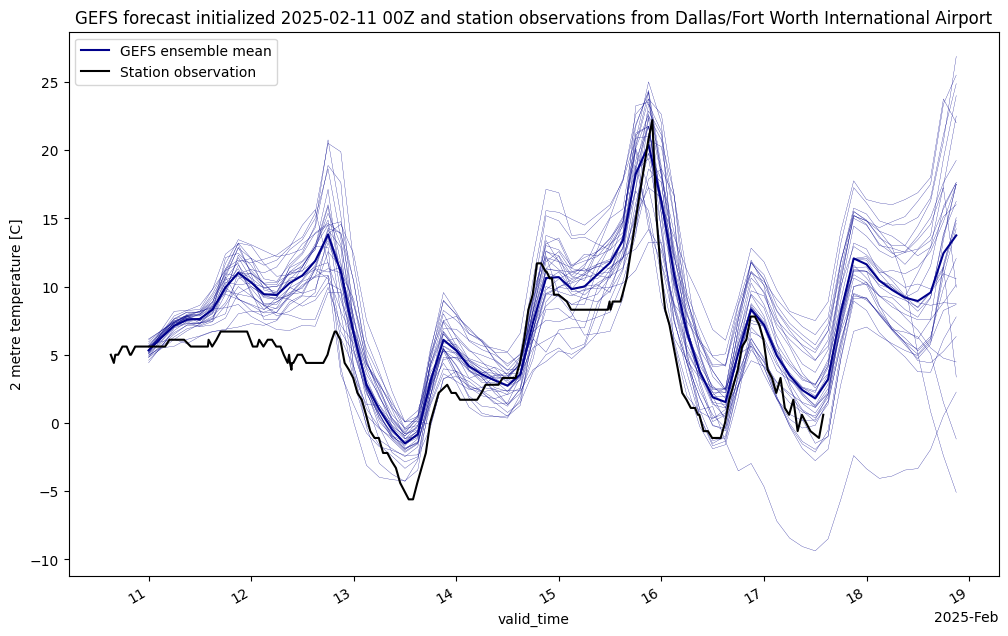

In [5]:
# Plot a GEFS forecast and recent station observations
plot_ds = gefs_ds.sel(
    init_time=start_time_utc,
    longitude=station_lon,
    latitude=station_lat,
    method="nearest"
).sel(lead_time=slice("0h", "7d"))

figure, axes = plt.subplots(figsize=(12, 8))

plot_ds["temperature_2m"].plot(x="valid_time", hue="ensemble_member", c="darkblue", linewidth=0.2, ax=axes)
plot_ds["temperature_2m_avg"].plot(x="valid_time", c="darkblue", label="GEFS ensemble mean", ax=axes)

station_df["temperature"].plot(c="black", label="Station observation", ax=axes)

axes.set_title(f"GEFS forecast initialized {plot_ds.init_time.dt.strftime('%Y-%m-%d %HZ').item()} "
               f"and station observations from {station_info['properties']['name']}")
axes.legend()

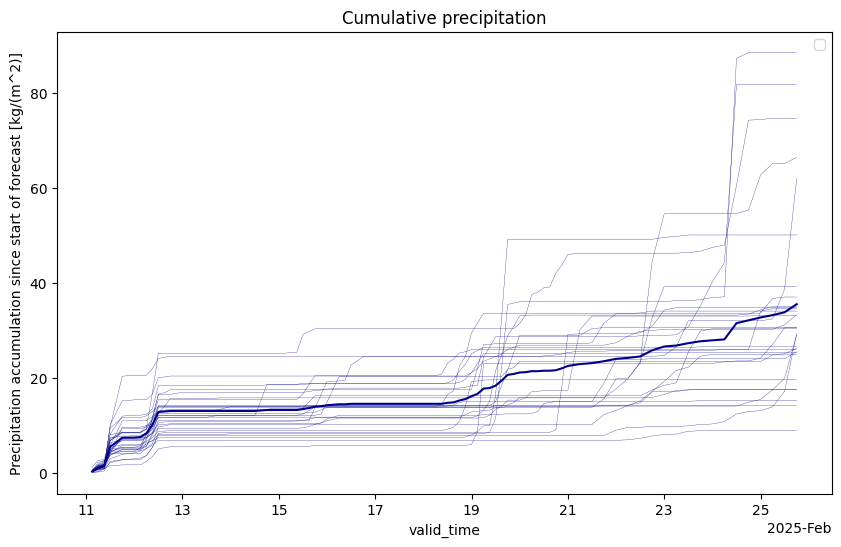

In [ ]:
# Plot the cumulative precipitation since the start of the forecast

# Select the initialization, location, and range of lead times
plot_ds = gefs_ds.sel(
    init_time=start_time_utc,
    longitude=station_lon,
    latitude=station_lat,
    method="nearest"
).sel(lead_time=slice("0h", "14d"))

# Cumulative sum to calculate the accumulation since the start of the forecast.
cumulative_plot_ds = plot_ds.cumulative(dim="lead_time").sum()
# Add back coordinates that we loose during the cumulative sum (xarray can't be sure they are still correct)
cumulative_plot_ds = cumulative_plot_ds.assign_coords(valid_time=plot_ds.valid_time, lead_time=plot_ds.lead_time) 

cumulative_plot_ds["precipitation_surface"].plot(x="valid_time", hue="ensemble_member", c="darkblue", linewidth=0.2, figsize=(10, 6))
cumulative_plot_ds["precipitation_surface_avg"].plot(x="valid_time", c="darkblue")

plt.title("Cumulative precipitation")
plt.ylabel(f"Precipitation accumulation since start of forecast [{gefs_ds['precipitation_surface'].attrs['units']}]")
plt.legend([])  # turn off large legend

## Large scale analysis
The dynamical.org GEFS forecast zarr enables efficient, large scale analysis. Let's see an example.


In [7]:
# First, retrieve a lot of stations from the NOAA API

def get_noaa_stations(limit=500, state=None):
    """
    Returns a GeoDataFrame of NOAA weather stations from api.weather.gov.
    Provide a two letter state (eg. "TX") to return stations within that state.
    """
    params = {"state": state} if state else {}
    stations_response = requests.get("https://api.weather.gov/stations", params=params).json()
    stations_gdfs = [gpd.GeoDataFrame.from_features(stations_response["features"])]
    num_stations = len(stations_gdfs[0])
    while (next_page := stations_response["pagination"].get("next")) and num_stations < limit:
        stations_response = requests.get(next_page).json()
        stations_page = gpd.GeoDataFrame.from_features(stations_response["features"])
        stations_gdfs.append(stations_page)
        num_stations += len(stations_page)
        print(".", end="", flush=True)
    return pd.concat(stations_gdfs, axis="index")

stations_df = get_noaa_stations(limit=1500)
stations_df

..

,geometry,@id,@type,elevation,stationIdentifier,name,timeZone,forecast,county,fireWeatherZone
0,POINT (-84.1787 30.53099),https://api.weather.gov/stations/0007W,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 49.0728}",0007W,Montford Middle,America/New_York,https://api.weather.gov/zones/forecast/FLZ017,https://api.weather.gov/zones/county/FLC073,https://api.weather.gov/zones/fire/FLZ017
1,POINT (-121.33943 36.78921),https://api.weather.gov/stations/000PG,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 129.2352}",000PG,Southside Road,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ528,https://api.weather.gov/zones/county/CAC069,https://api.weather.gov/zones/fire/CAZ528
2,POINT (-117.8552 34.11814),https://api.weather.gov/stations/000SE,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 242.9256}",000SE,SCE South Hills Park,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ548,https://api.weather.gov/zones/county/CAC037,https://api.weather.gov/zones/fire/CAZ548
3,POINT (-156.54018 20.80393),https://api.weather.gov/stations/001HE,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 571.1952}",001HE,MECO Kealaloloa Ridge,Pacific/Honolulu,https://api.weather.gov/zones/forecast/HIZ046,https://api.weather.gov/zones/county/HIC009,https://api.weather.gov/zones/fire/HIZ330
4,POINT (-156.32 20.7579),https://api.weather.gov/stations/001HI,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 964.0824}",001HI,Kula Ag,Pacific/Honolulu,https://api.weather.gov/zones/forecast/HIZ049,https://api.weather.gov/zones/county/HIC009,https://api.weather.gov/zones/fire/HIZ333
...,...,...,...,...,...,...,...,...,...,...
495,POINT (-117.21336 33.66348),https://api.weather.gov/stations/345SE,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 459.9432}",345SE,SCE Craig Ave,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ048,https://api.weather.gov/zones/county/CAC065,https://api.weather.gov/zones/fire/CAZ248
496,POINT (-89.4649 31.3876),https://api.weather.gov/stations/346BX,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 85.9536}",346BX,346B Hattiesburg,America/Chicago,https://api.weather.gov/zones/forecast/MSZ073,https://api.weather.gov/zones/county/MSC073,https://api.weather.gov/zones/fire/MSZ073
497,POINT (-122.28975 38.61576),https://api.weather.gov/stations/346PG,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 148.7424}",346PG,Chaparral Cove,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ504,https://api.weather.gov/zones/county/CAC055,https://api.weather.gov/zones/fire/CAZ504
498,POINT (-117.19379 33.67039),https://api.weather.gov/stations/346SE,wx:ObservationStation,"{'unitCode': 'wmoUnit:m', 'value': 447.1416}",346SE,SCE Holland Rd,America/Los_Angeles,https://api.weather.gov/zones/forecast/CAZ048,https://api.weather.gov/zones/county/CAC065,https://api.weather.gov/zones/fire/CAZ248


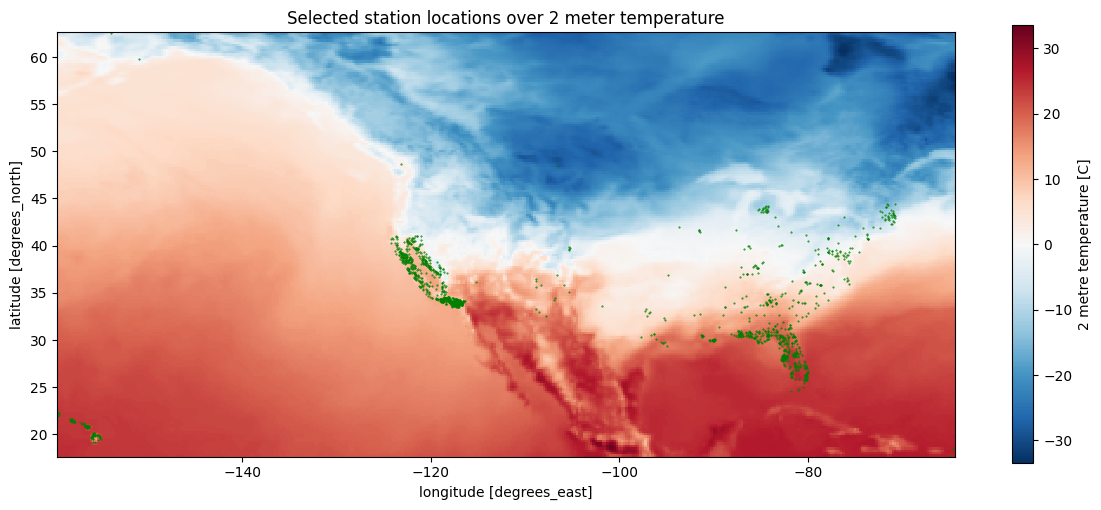

In [8]:
# Plot the locations of the stations we have on top of 2 meter temperature for context

fig, ax = plt.subplots(figsize=(12, 5))
(
    gefs_ds["temperature_2m_avg"]
    .rio.clip_box(*stations_df.total_bounds)
    .sel(init_time=start_time_utc, lead_time="0h", method="nearest")
    .plot(ax=ax)
)
stations_df.plot(c="green", markersize=0.2, ax=ax)
ax.set_title("Selected station locations over 2 meter temperature")
plt.tight_layout()

In [9]:
# The xvec library makes it easy to extract out thousands of points or compute zonal statistics
stations_gefs_ds = gefs_ds.xvec.extract_points(
    stations_df.geometry, x_coords="longitude", y_coords="latitude", name="station"
)
# Add the station id and name as coordinate labels along the station dimension of our GEFS dataset
stations_gefs_ds = stations_gefs_ds.assign_coords(
    station_id=("station", stations_df["stationIdentifier"]),
    station_name=("station", stations_df["name"])
)
stations_gefs_ds

<xarray.Dataset> Size: 272GB
Dimensions:                                         (init_time: 414,
                                                     ensemble_member: 31,
                                                     lead_time: 181,
                                                     station: 1500)
Coordinates:
  * ensemble_member                                 (ensemble_member) uint16 62B ...
    expected_forecast_length                        (init_time) timedelta64[ns] 3kB dask.array<chunksize=(414,), meta=np.ndarray>
    ingested_forecast_length                        (init_time, ensemble_member) timedelta64[ns] 103kB dask.array<chunksize=(414, 31), meta=np.ndarray>
  * init_time                                       (init_time) datetime64[ns] 3kB ...
  * lead_time                                       (lead_time) timedelta64[ns] 1kB ...
    spatial_ref                                     int64 8B ...
    valid_time                                      (init_time, lead_time) datetime64[ns] 599kB dask.array<chunksize=(414, 181), meta=np.ndarray>
  * station                                         (station) object 12kB POI...
    index                                           (station) int64 12kB 0 .....
    station_id                                      (station) object 12kB '00...
    station_name                                    (station) object 12kB 'Mo...
Data variables: (12/34)
    categorical_freezing_rain_surface               (init_time, ensemble_member, lead_time, station) float32 14GB dask.array<chunksize=(1, 31, 181, 1500), meta=np.ndarray>
    categorical_freezing_rain_surface_avg           (init_time, lead_time, station) float32 450MB dask.array<chunksize=(1, 181, 1500), meta=np.ndarray>
    categorical_ice_pellets_surface                 (init_time, ensemble_member, lead_time, station) float32 14GB dask.array<chunksize=(1, 31, 181, 1500), meta=np.ndarray>
    categorical_ice_pellets_surface_avg             (init_time, lead_time, station) float32 450MB dask.array<chunksize=(1, 181, 1500), meta=np.ndarray>
    categorical_rain_surface                        (init_time, ensemble_member, lead_time, station) float32 14GB dask.array<chunksize=(1, 31, 181, 1500), meta=np.ndarray>
    categorical_rain_surface_avg                    (init_time, lead_time, station) float32 450MB dask.array<chunksize=(1, 181, 1500), meta=np.ndarray>
    ...                                              ...
    wind_u_100m                                     (init_time, ensemble_member, lead_time, station) float32 14GB dask.array<chunksize=(1, 31, 181, 1500), meta=np.ndarray>
    wind_u_10m                                      (init_time, ensemble_member, lead_time, station) float32 14GB dask.array<chunksize=(1, 31, 181, 1500), meta=np.ndarray>
    wind_u_10m_avg                                  (init_time, lead_time, station) float32 450MB dask.array<chunksize=(1, 181, 1500), meta=np.ndarray>
    wind_v_100m                                     (init_time, ensemble_member, lead_time, station) float32 14GB dask.array<chunksize=(1, 31, 181, 1500), meta=np.ndarray>
    wind_v_10m                                      (init_time, ensemble_member, lead_time, station) float32 14GB dask.array<chunksize=(1, 31, 181, 1500), meta=np.ndarray>
    wind_v_10m_avg                                  (init_time, lead_time, station) float32 450MB dask.array<chunksize=(1, 181, 1500), meta=np.ndarray>
Indexes:
    station  GeometryIndex (crs=None)
Attributes:
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    dataset_id:           noaa-gefs-forecast
    description:          Weather forecasts from the Global Ensemble Forecast...
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...
    name:                 NOAA GEFS forecast
    spatial_domain:       Global
    spatial_resolution:   0-240 hours: 0.25 degrees (~20

Text(0.5, 1.0, 'Ensemble mean precipitation forecasts at 1500 weather stations')

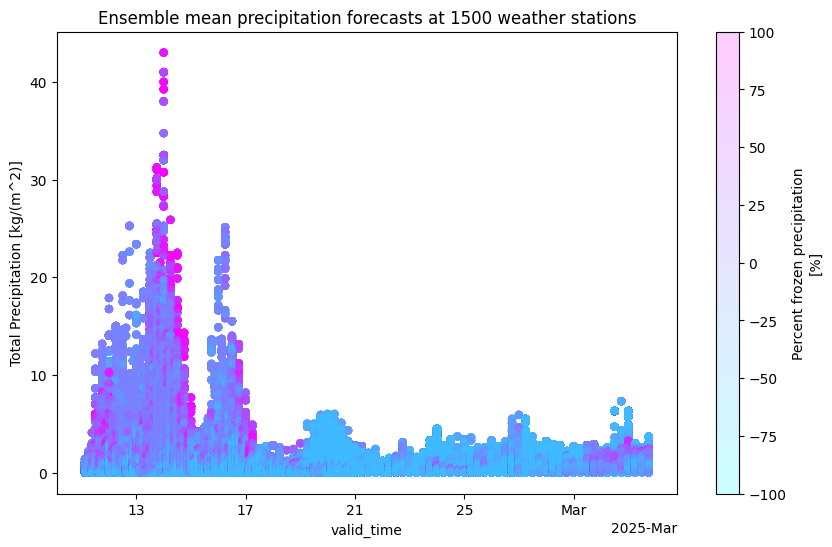

In [10]:
# Make a precipitation forecast scatter plot with forecasts from every station.
# Color the dots by rain or not rain.
(
    stations_gefs_ds
    .sel(init_time="2025-02-11T00")
    .sel(lead_time=slice("0h", "20d"))
).plot.scatter(
    x="valid_time",
    y="precipitation_surface_avg",
    hue="percent_frozen_precipitation_surface",
    cmap="cool",
    alpha=0.2,
    linewidths=0,
    figsize=(10, 6),
)
plt.title(f"Ensemble mean precipitation forecasts at {len(stations_gefs_ds.station)} weather stations")

In [11]:
# Create a table of stations sorted by the ensemble average precipitation
# accumulation forecast for the first 48 hours of the selected forecast
(
    stations_gefs_ds["precipitation_surface_avg"]
    .sel(init_time=start_time_utc, method="nearest")
    .sel(lead_time=stations_gefs_ds.lead_time < pd.Timedelta(hours=48))
    .sum(dim="lead_time")  # accumulate precipitation
    .to_dataframe()
    .sort_values("precipitation_surface_avg", ascending=False)
    [["station_id", "station_name", "precipitation_surface_avg"]]
)

,station_id,station_name,precipitation_surface_avg
station,,,
POINT (-91.4036 32.7032),143BX,143B Pioneer,124.550781
POINT (-92.06999 32.59848),1315W,Ouachita Christian School,118.447266
POINT (-88.81916 33.4445),2093W,Starkville Academy,93.597656
POINT (-88.79258 33.4572),2091W,Mississippi State University,93.597656
POINT (-86.55164 34.6961),1575W,Randolph School,78.005615
...,...,...,...
POINT (-122.39539 40.48043),103PG,Kiwi Lane,0.000000
POINT (-121.88686 39.83897),237PG,Camenzind Court,0.000000
POINT (-120.66758 38.56751),240PG,Mine Road,0.000000
